In [1]:
import numpy as np
from scipy import optimize as sp_optimize

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled

In [2]:
def sample_mixgauss(wk, sk, size):
    runif = np.random.uniform(0, 1, size = size)
    gcomp = np.digitize(runif, np.cumsum(wk))
    x = np.zeros(size)
    for i, gc in enumerate(gcomp):
        if sk[gc] > 0:
            x[i] = np.random.normal(0, sk[gc]) 
    return x

def NM_sample(mean, std = 1.0):
    p   = mean.shape[0]
    cov = np.eye(p) * std * std
    y   = np.random.multivariate_normal(mean, cov)
    return y

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

In [11]:
p = 500
k = 4
sparsity = 0.4
strue = 1.0

np.random.seed(100)
wtrue, sk = initialize_ash_prior(k, sparsity = sparsity)
sk = np.logspace(-1, k-2, k)
btrue = sample_mixgauss(wtrue, sk, p)
y = NM_sample(btrue, std = strue)
dj = np.ones(p)

In [12]:
wtrue

array([0.4, 0.2, 0.2, 0.2])

In [13]:
strue

1.0

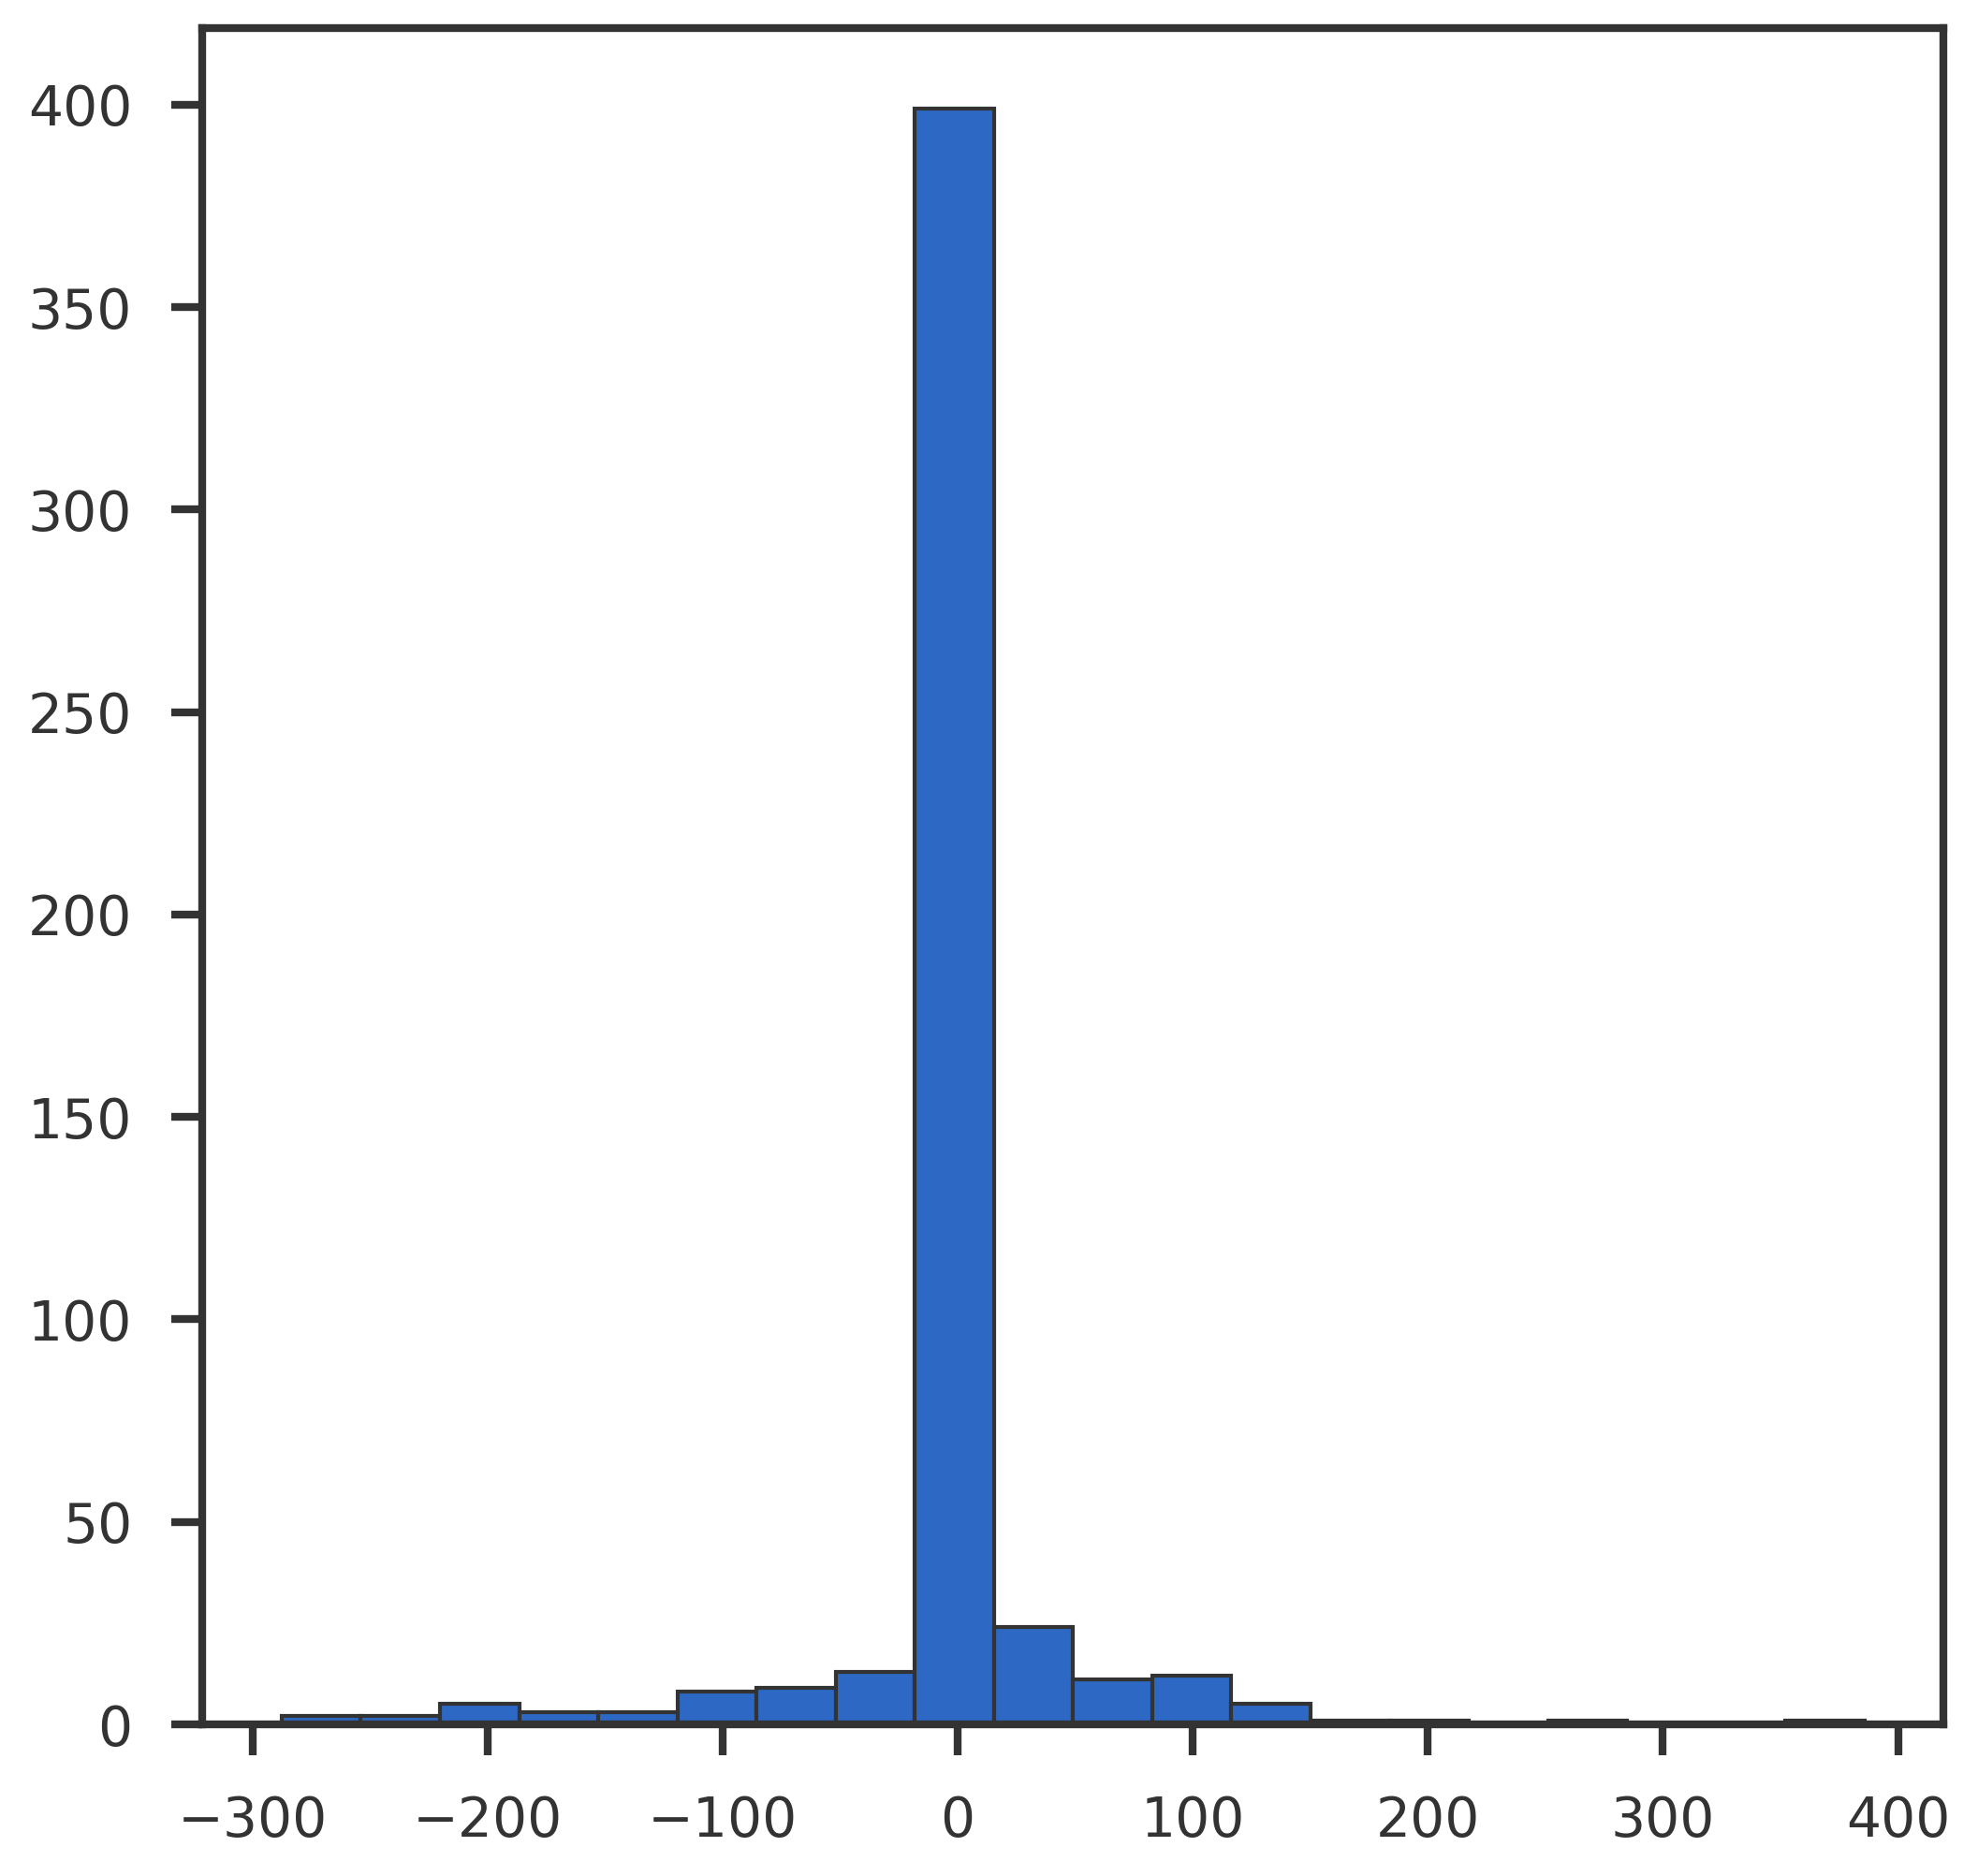

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(btrue)
#ax1.hist(mean)
plt.show()

In [16]:
def softmax(x, base = np.exp(1)):
    if base is not None:
        beta = np.log(base)
        x = x * beta
    e_x = np.exp(x - np.max(x))
    return e_x / np.sum(e_x, axis = 0, keepdims = True)

def penalty_operator(z, wk, std, sk, dj):
    nm = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    tvar = (std * std) / dj
    lambdaj = - nm.logML - 0.5 * tvar * np.square(nm.logML_deriv)
    return lambdaj

def shrinkage_operator(nm):
    M        = nm.y + nm.yvar * nm.logML_deriv
    M_bgrad  = 1       + nm.yvar * nm.logML_deriv2
    M_wgrad  = nm.yvar.reshape(-1, 1) * nm.logML_deriv_wderiv
    M_s2grad = (nm.logML_deriv / nm._d) + (nm.yvar * nm.logML_deriv_s2deriv)
    return M, M_bgrad, M_wgrad, M_s2grad

def unshrink_b(b, std, wk, sk, dj, theta = None, max_iter = 100, tol = 1e-8):
    # this is the initial value of theta
    if theta is None:
        theta = np.zeros_like(b)
    # Newton-Raphson iteration
    for itr in range(max_iter):
        nmash = NormalMeansASHScaled(theta, std, wk, sk, d = dj)
        Mtheta, Mtheta_bgrad, _, _ = shrinkage_operator(nmash)
        theta_new = theta - (Mtheta - b) / Mtheta_bgrad
        diff = np.sum(np.square(theta_new - theta))
        theta = theta_new
        obj = np.sum(- nmash.logML - 0.5 * nmash.yvar * np.square(nmash.logML_deriv))
        print(obj)
        if diff <= tol:
            break
    return theta

def shrink_theta(z, std, wk, sk, dj):
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    Mb = shrinkage_operator(nmash)[0]
    return Mb

def penalty_operator_lagrangian(z, wk, std, sk, dj, lgrng, b):
    Mt  = shrink_theta(z, std, wk, sk, dj)
    hwt = penalty_operator(z, wk, std, sk, dj)
    obj = np.sum(hwt) + np.sum(lgrng * (Mt - b))
    return obj

def penalty_operator_lagrangian_deriv(z, wk, std, sk, dj, lgrng, b):
    '''
    The Normal Means model
    '''
    nmash = NormalMeansASHScaled(z, std, wk, sk, d = dj)
    '''
    gradient w.r.t lambda_j (lagrangian penalty)
    '''
    M, M_bgrad, M_wgrad, M_s2grad  = shrinkage_operator(nmash)
    dLdl = M - b
    '''
    gradient w.r.t wk (prior mixture coefficients)
    '''
    tvar  = (strue * strue) / dj
    v2_ld_ldwd = tvar.reshape(-1, 1) * nmash.logML_deriv.reshape(-1, 1) * nmash.logML_deriv_wderiv
    ## gradient of first term and second term of the lagrangian
    l1_wgrad = - nmash.logML_wderiv - v2_ld_ldwd
    l2_wgrad = lgrng.reshape(-1, 1) * M_wgrad
    dLdw = np.sum(l1_wgrad + l2_wgrad, axis = 0)
    '''
    gradient w.r.t theta
    '''
    l1_tgrad = - nmash.logML_deriv  - tvar * nmash.logML_deriv * nmash.logML_deriv2
    l2_tgrad = lgrng * (1 + tvar * nmash.logML_deriv2)
    dLdt = l1_tgrad + l2_tgrad
    return dLdl, dLdw, dLdt

def objective_numeric_lagrangian(params, std, sk, dj, b, p, k, softmax_base):
    zj = params[:p]
    lj = params[p:2*p]
    ak = params[2*p:]
    wk = softmax(ak, base = softmax_base)
    dLdl, dLdw, dLdt = penalty_operator_lagrangian_deriv(zj, wk, strue, sk, dj, lj, btrue)
    akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
    dLda = np.sum(dLdw * akjac, axis = 1)
    obj = np.sqrt(np.sum(np.square(dLdl)) + np.sum(np.square(dLda)) + np.sum(np.square(dLdt)))
    return obj

748.1862973358625
4203.277954867171
1655.2902083317954
1775.7582978442942
1711.1259679743866
1709.997646920945
1709.8544395794902


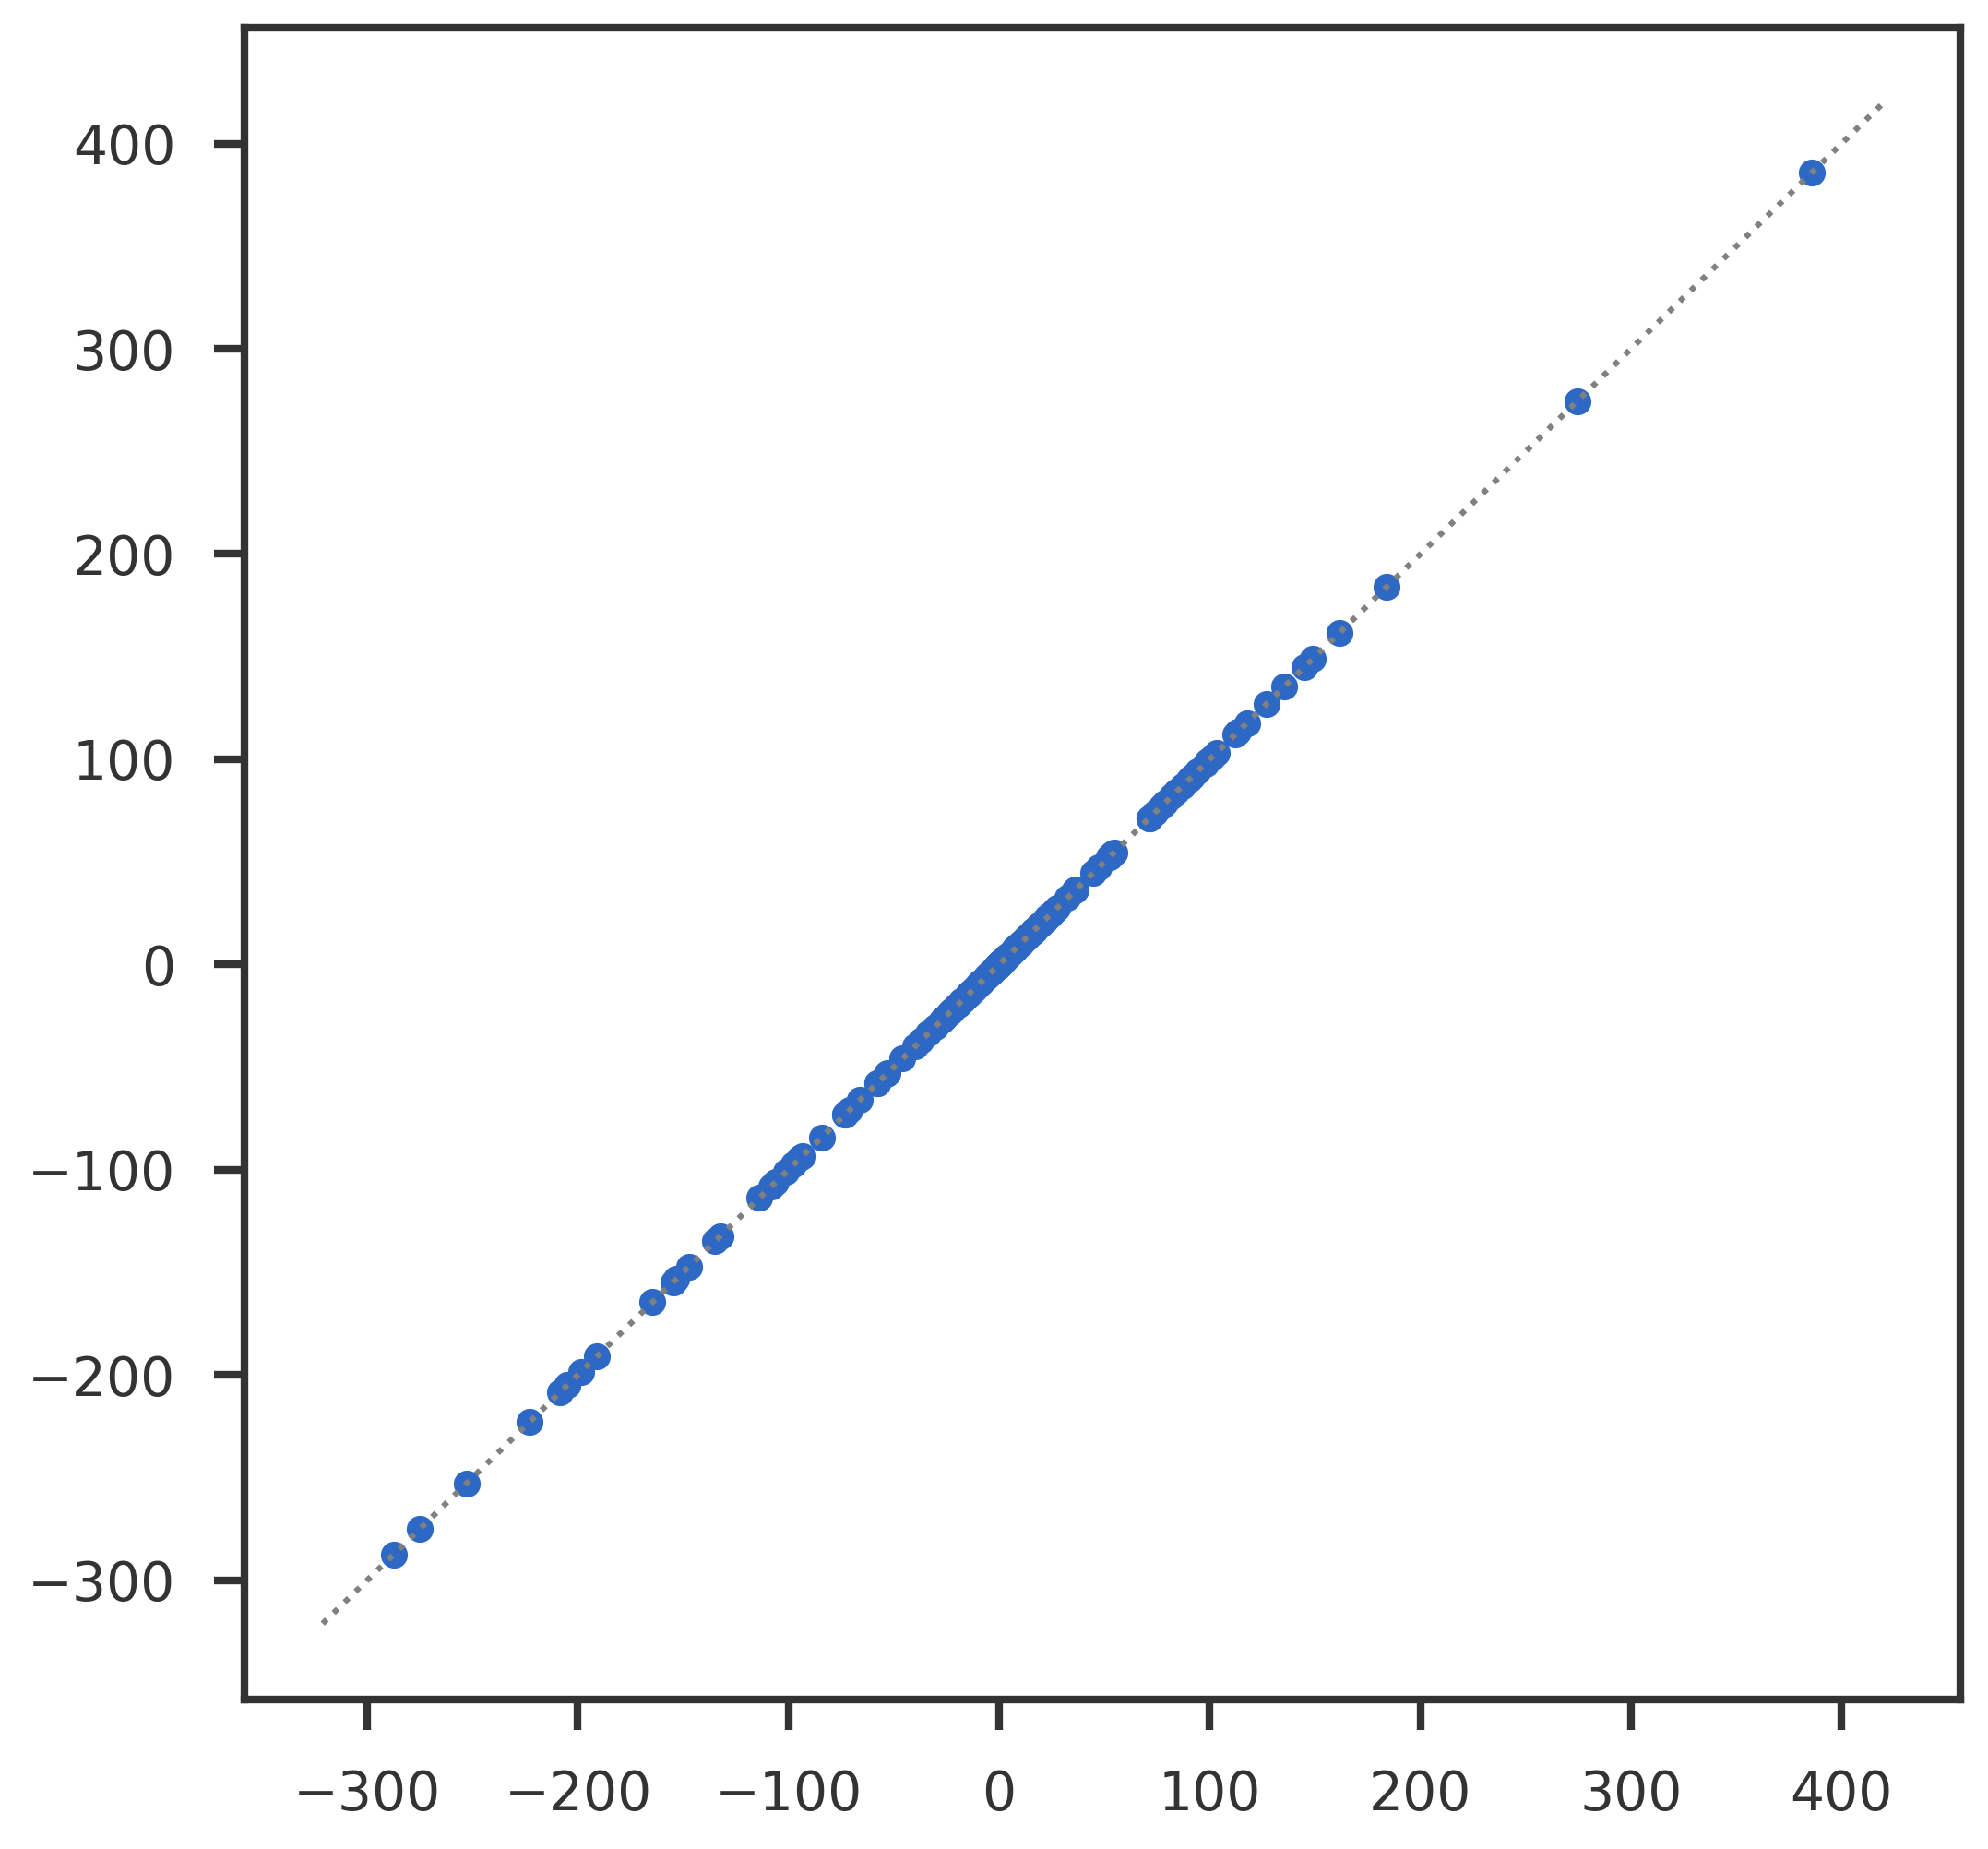

In [17]:
z_newraph = unshrink_b(btrue, strue, wtrue, sk, dj)
b_newraph = shrink_theta(z_newraph, strue, wtrue, sk, dj)
objtrue   = penalty_operator(z_newraph, wtrue, strue, sk, dj)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(btrue, b_newraph)
mpl_utils.plot_diag(ax1)

In [34]:
z = np.random.rand(p)
softmax_base = np.exp(1)
winit, _ = initialize_ash_prior(k)
akinit = np.log(winit + 1e-8) / np.log(softmax_base)

In [35]:
winit

array([0.25, 0.25, 0.25, 0.25])

In [36]:
akinit

array([-1.38629432, -1.38629432, -1.38629432, -1.38629432])

In [37]:
lgrng = np.ones(btrue.shape[0]) * 2.0
wk  = softmax(akinit, base = softmax_base)
obj = penalty_operator_lagrangian(z, wk, strue, sk, dj, lgrng, btrue)
print(obj)

10951.488699472626


In [38]:
lindx = 0
eps = 1e-8
lj_deriv_numeric = np.zeros(p)
for indx in range(p):
    lgrng_eps = lgrng.copy()
    lgrng_eps[indx] += eps
    obj_eps = penalty_operator_lagrangian(z, wk, strue, sk, dj, lgrng_eps, btrue)
    lj_deriv_numeric[indx] = (obj_eps - obj) / eps
lj_deriv_analytic = penalty_operator_lagrangian_deriv(z, wk, strue, sk, dj, lgrng, btrue)[0]
print(lj_deriv_numeric[lindx])
print(lj_deriv_analytic[lindx])

-0.20081643015146255
-0.2008641974467279


In [39]:
np.allclose(lj_deriv_numeric, lj_deriv_analytic, rtol = 1e-8, atol = 1e-4)

False

In [47]:
eps = 1e-8
ak_deriv_numeric = np.zeros(k)
for indx in range(k):
    ak_eps = akinit.copy()
    ak_eps[indx] += eps
    wk_eps = softmax(ak_eps, base = softmax_base)
    obj_eps = penalty_operator_lagrangian(z, wk_eps, strue, sk, dj, lgrng, btrue)
    ak_deriv_numeric[indx] = (obj_eps - obj) / eps
akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
dLdw  = penalty_operator_lagrangian_deriv(z, wk, strue, sk, dj, lgrng, btrue)[1]
ak_deriv_analytic = np.sum(dLdw * akjac, axis = 1)
print(ak_deriv_numeric)
print(ak_deriv_analytic)

[-894.41346063  -94.15125533  489.45657909  499.10850066]
[-894.41356912  -94.15112272  489.45649586  499.10819599]


In [52]:
np.allclose(ak_deriv_numeric, ak_deriv_analytic, rtol = 1e-8, atol = 1e-4)

False

In [53]:
eps = 1e-4
theta_deriv_numeric = np.zeros(p)
for indx in range(p):
    theta_eps = z.copy()
    theta_eps[indx] += eps
    obj_eps = penalty_operator_lagrangian(theta_eps, wk, strue, sk, dj, lgrng, btrue)
    theta_deriv_numeric[indx] = (obj_eps - obj) / eps
theta_deriv_analytic = penalty_operator_lagrangian_deriv(z, wk, strue, sk, dj, lgrng, btrue)[2]
print(theta_deriv_numeric)
print(theta_deriv_analytic)

[0.52749889 0.67331808 0.57466583 ... 0.70656708 1.04065652 0.66222286]
[0.52748837 0.67329306 0.57464988 ... 0.70653934 1.04060542 0.66219879]


In [54]:
np.allclose(theta_deriv_numeric, theta_deriv_analytic, rtol = 1e-8, atol = 1e-4)

True

In [55]:
dLdl, dLdw, dLdt = penalty_operator_lagrangian_deriv(z, wk, strue, sk, dj, lgrng, btrue)
akjac = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
dLda = np.sum(dLdw * akjac, axis = 1)

In [56]:
np.sqrt(np.sum(np.square(dLdl)) + np.sum(np.square(dLda)) + np.sum(np.square(dLdt)))

2299.3559719976

In [57]:
params = np.concatenate([z, lgrng, wk])
objective_numeric_lagrangian(params, strue, sk, dj, btrue, p, k, softmax_base = softmax_base)

2299.3559719976

In [21]:
initparams = np.concatenate([z, lgrng, akinit])
objmin = sp_optimize.minimize(objective_numeric_lagrangian, initparams,
                              args = (strue, sk, dj, btrue, p, k, softmax_base),
                              method = 'Nelder-Mead',
                              options = {'disp': True, 'maxiter': 1000}
                             )

[0.24102563 0.2769231  0.24102563 0.24102563]


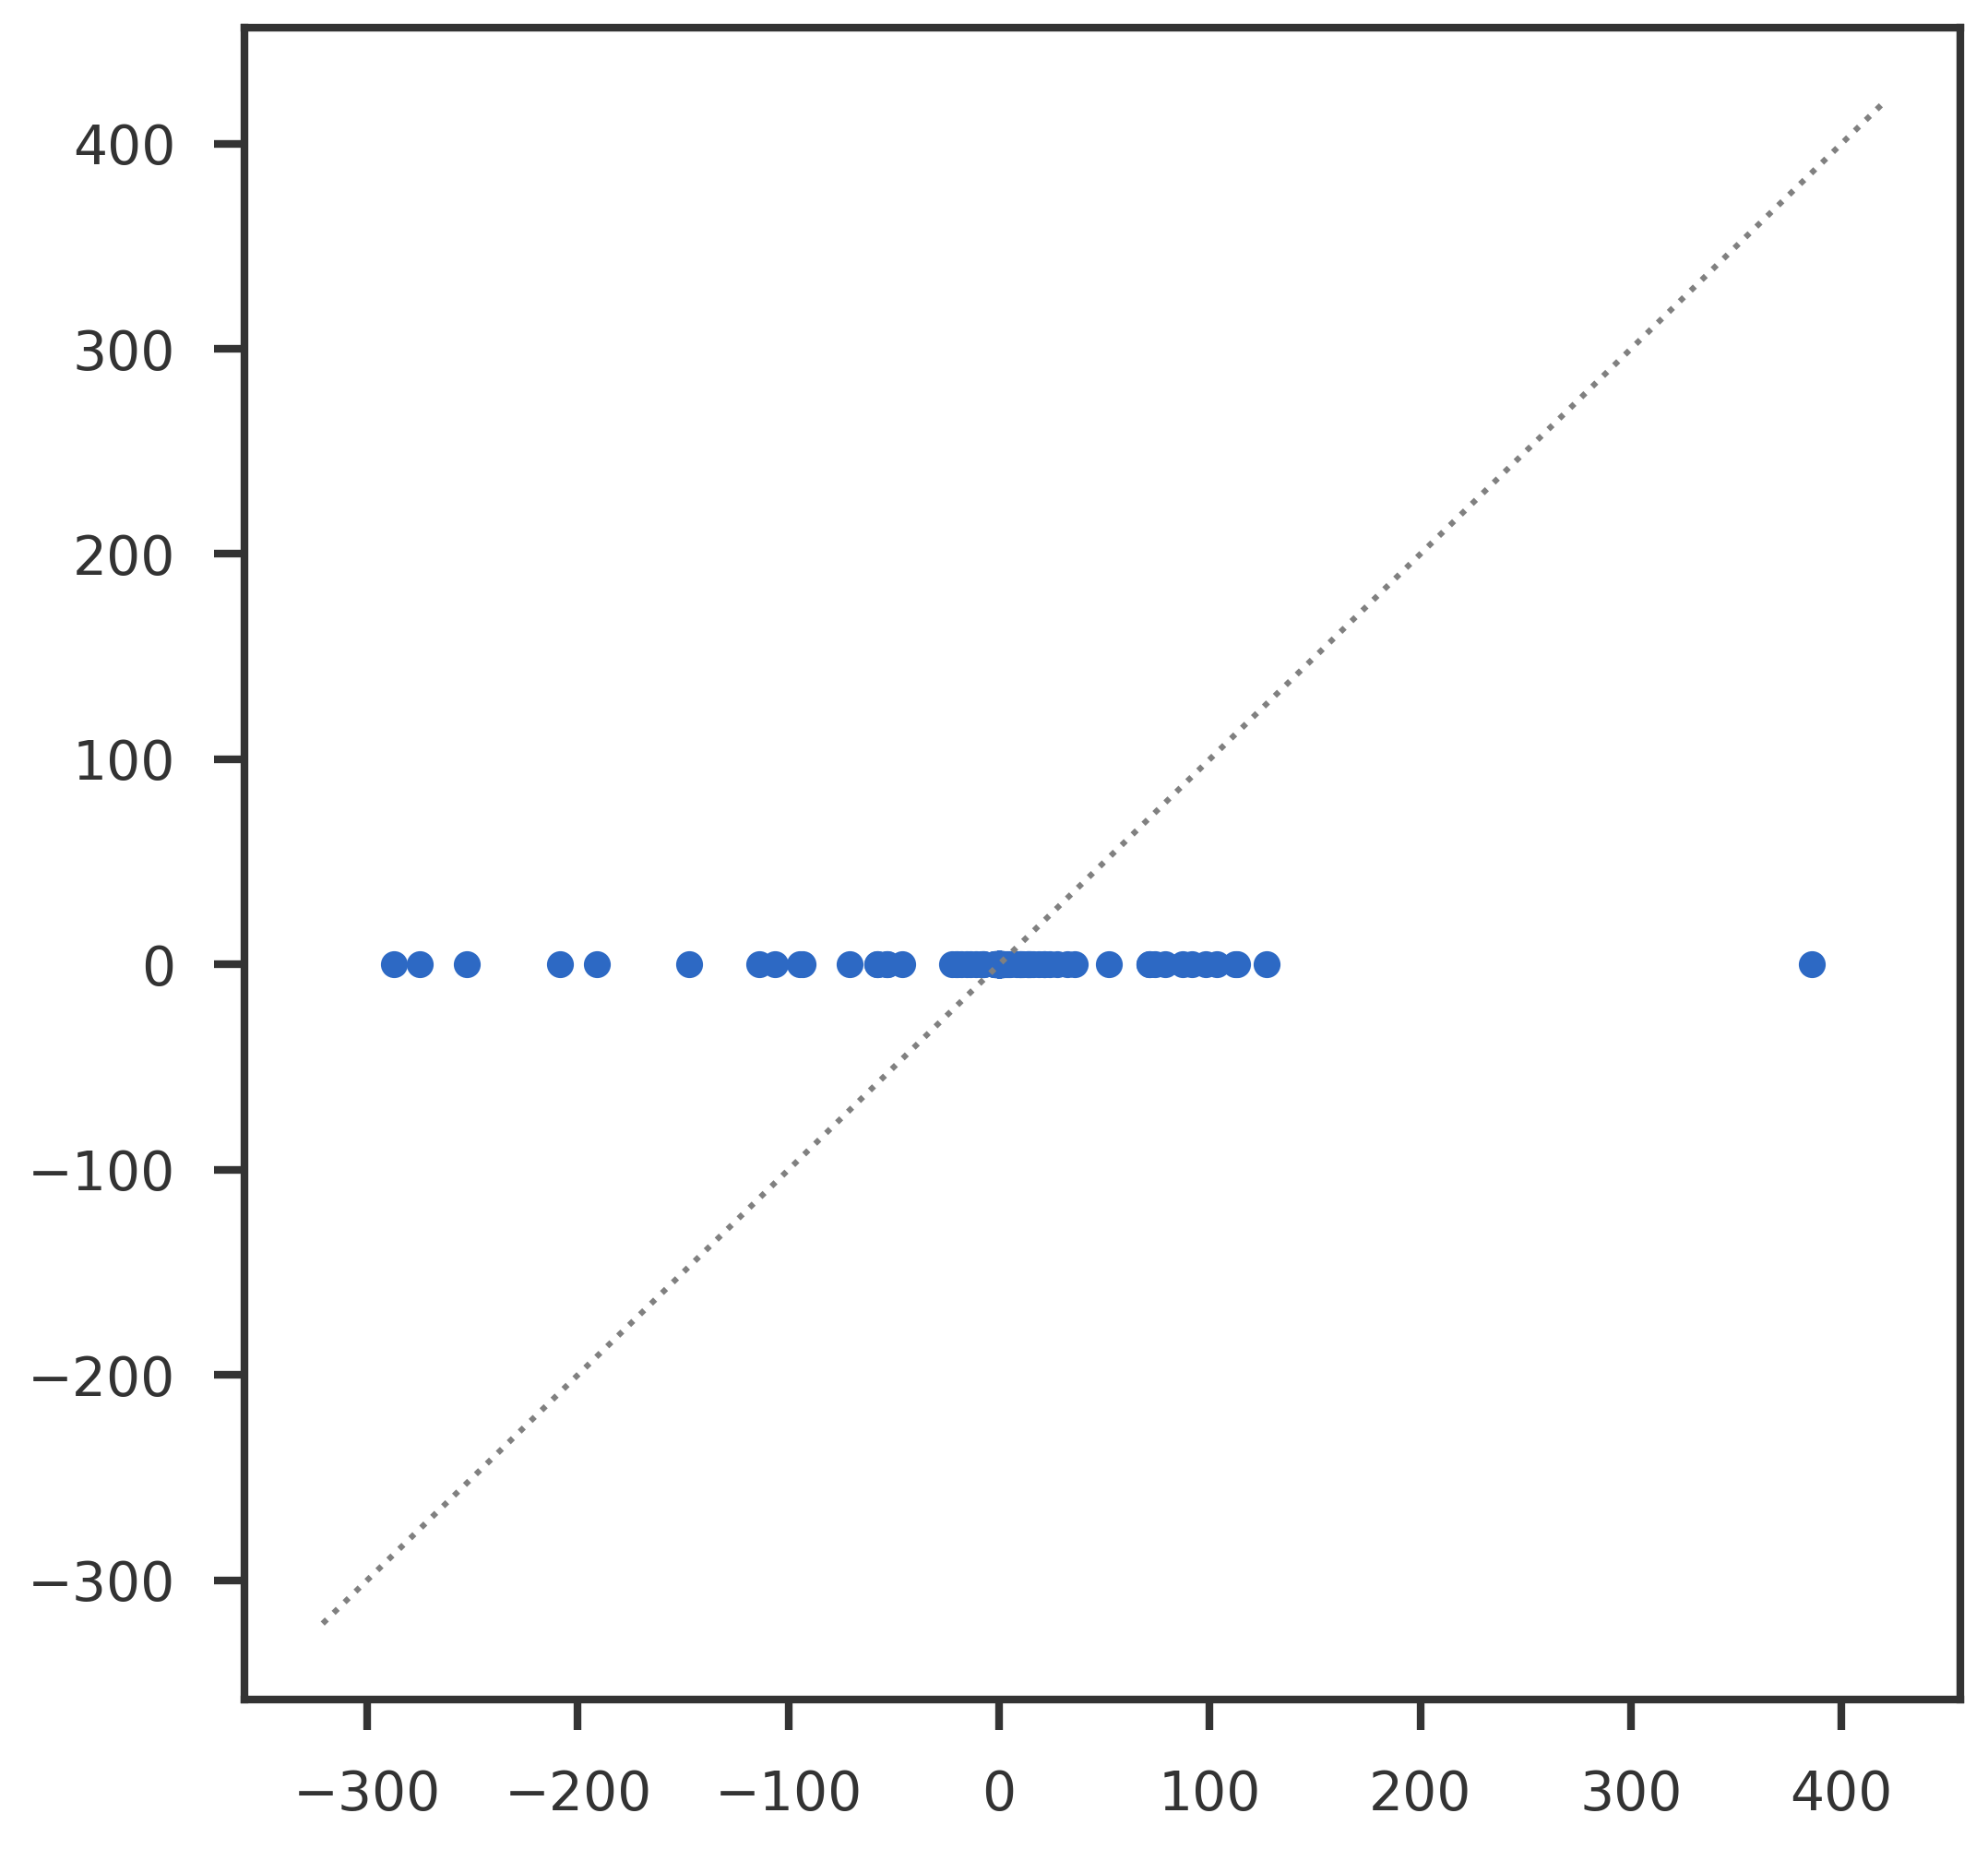

In [22]:
z_nelder_mead = objmin.x[:p]
a_nelder_mead = objmin.x[2*p:]
w_nelder_mead = softmax(a_nelder_mead, base = softmax_base)
print(w_nelder_mead)
b_nelder_mead = shrink_theta(z_nelder_mead, strue, w_nelder_mead, sk, dj)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(btrue, b_nelder_mead)
mpl_utils.plot_diag(ax1)

In [58]:
initparams = np.concatenate([z, lgrng, akinit])
cg_min = sp_optimize.minimize(objective_numeric_lagrangian, initparams,
                              args = (strue, sk, dj, btrue, p, k, softmax_base),
                              method = 'CG',
                              options = {'disp': True, 'maxiter': 6, 'return_all': True}
                             )

         Current function value: 562.780669
         Iterations: 6
         Function evaluations: 76095
         Gradient evaluations: 19


[2.11072639e-09 9.99997327e-01 2.49239591e-06 1.78166991e-07]


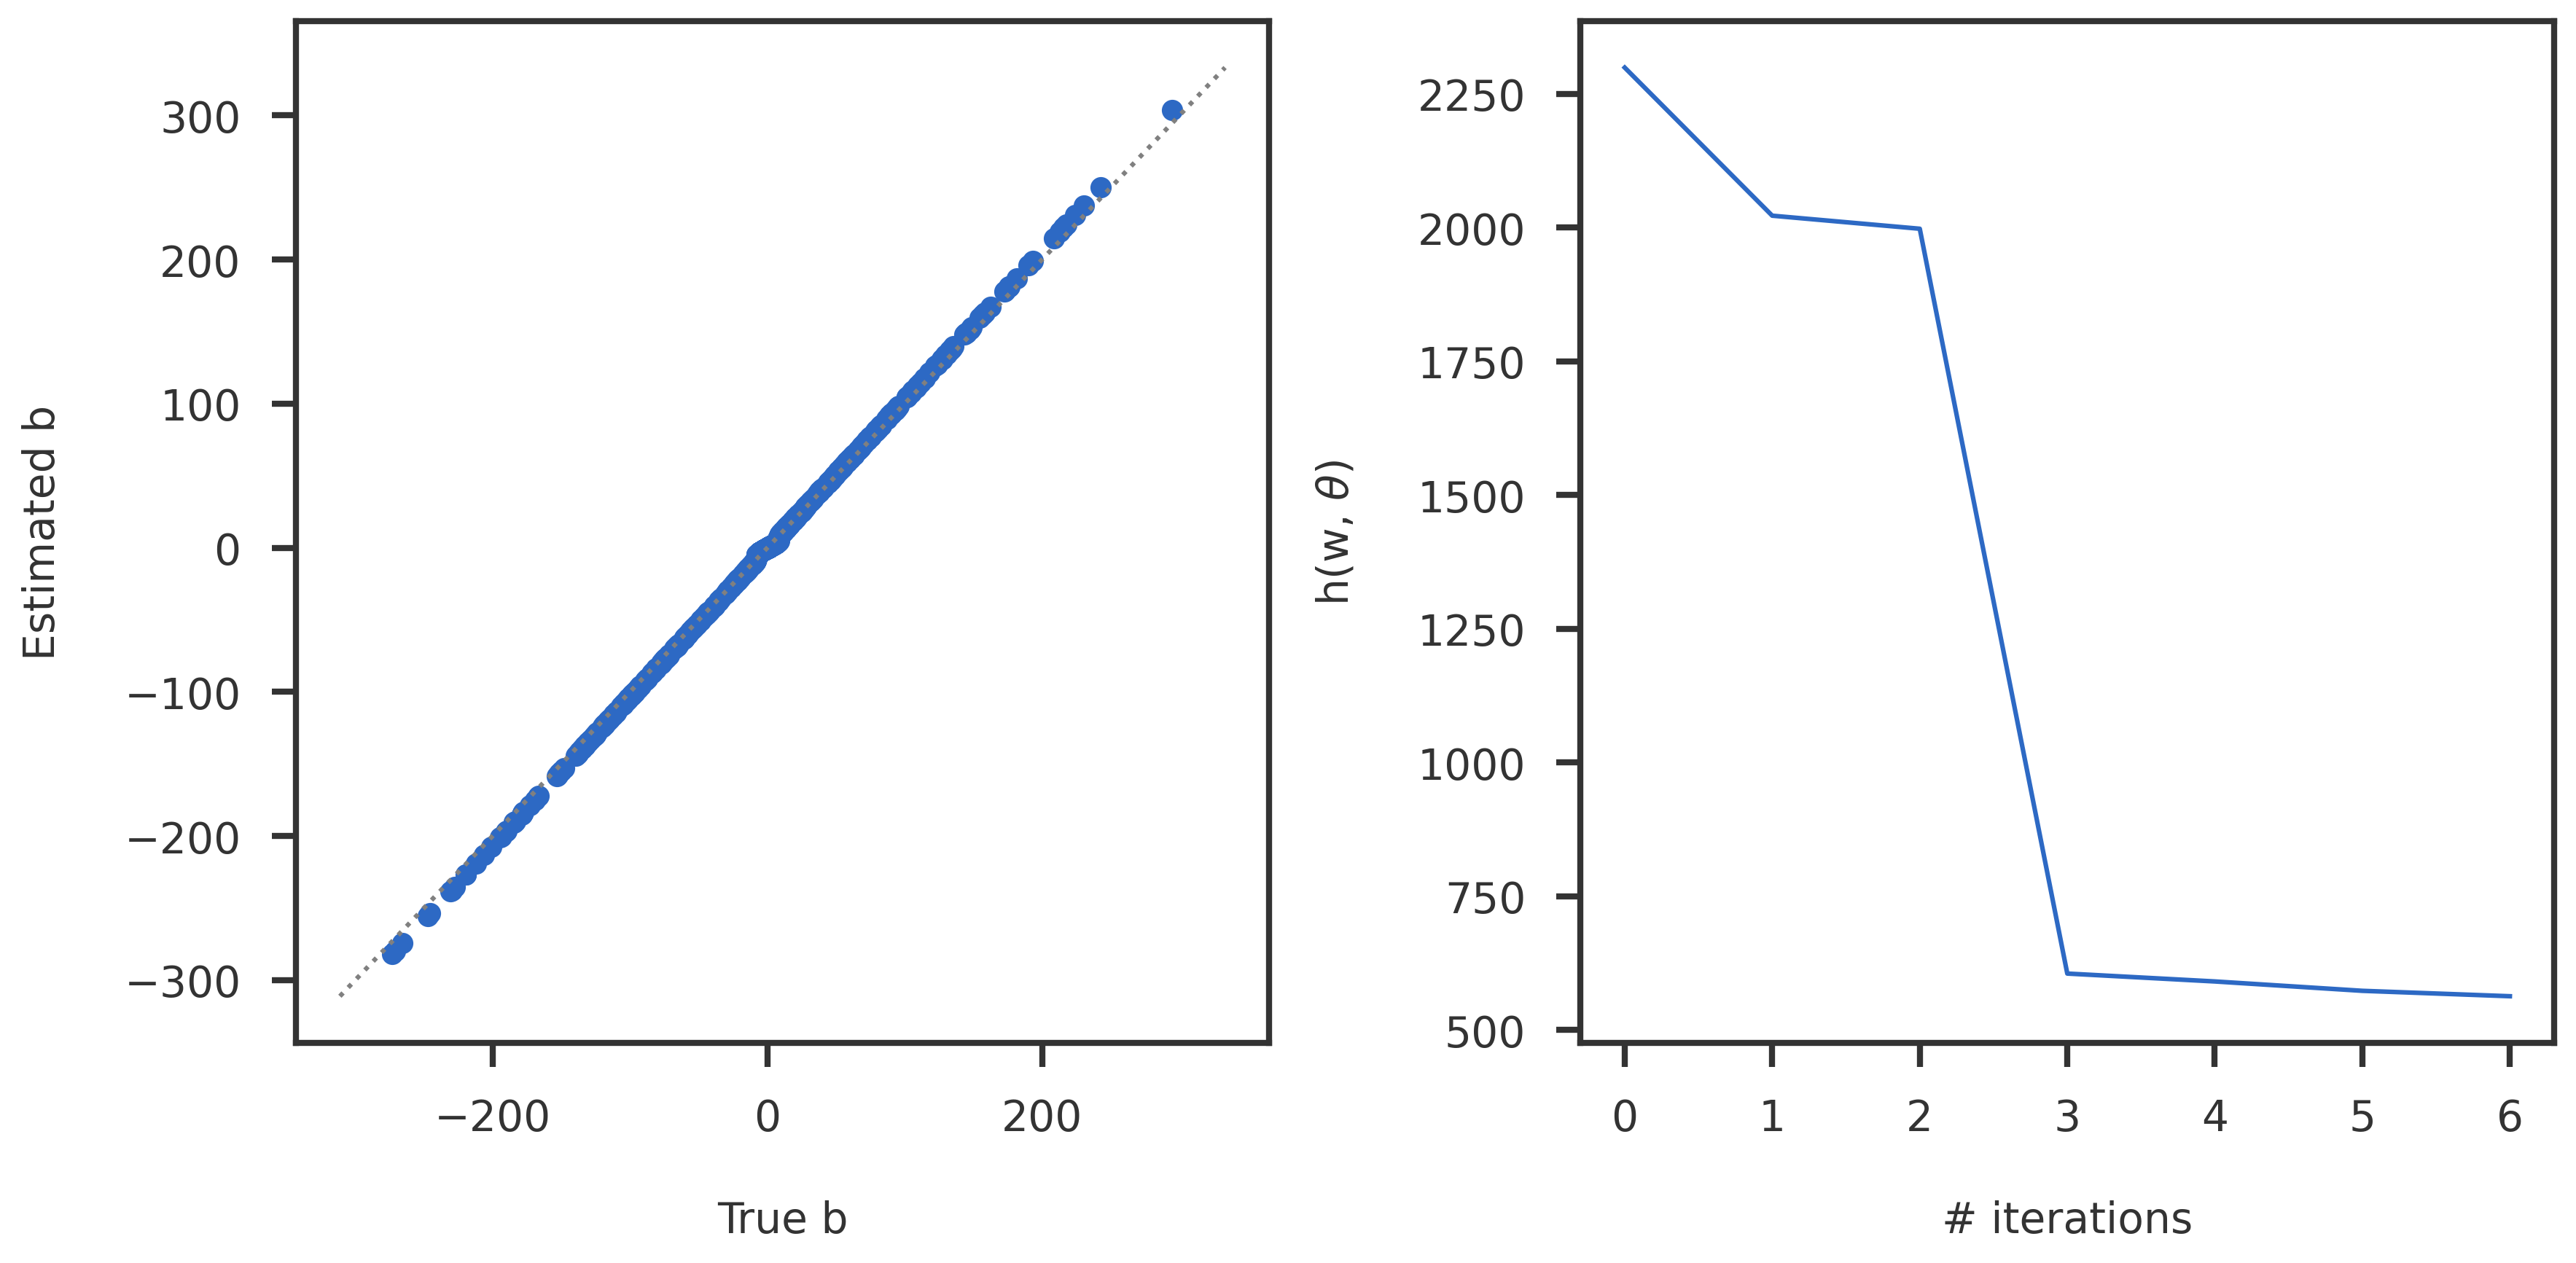

In [59]:
z_cg = cg_min.x[:p]
a_cg = cg_min.x[2*p:]
w_cg = softmax(a_cg, base = softmax_base)
print(w_cg)
b_cg = shrink_theta(z_cg, strue, w_cg, sk, dj)

fig = plt.figure(figsize = (12,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(btrue, b_cg)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel("True b")
ax1.set_ylabel("Estimated b")

niter   = cg_min.nit
allobjs = np.zeros(niter + 1)
for i, params in enumerate(cg_min.allvecs):
    z_it = params[:p]
    a_it = params[2*p:]
    lj_it = params[p:2*p]
    w_it = softmax(a_it, base = softmax_base)
    #alllagrangian[i] = penalty_operator_lagrangian(z_it, w_it, strue, sk, dj, lj_it, btrue)
    allobjs[i] = objective_numeric_lagrangian(params, strue, sk, dj, btrue, p, k, softmax_base)
ax2.plot(np.arange(niter + 1), allobjs)
ax2.set_xlabel("# iterations")
ax2.set_ylabel(r"h(w, $\theta$)")

plt.tight_layout()

plt.show()

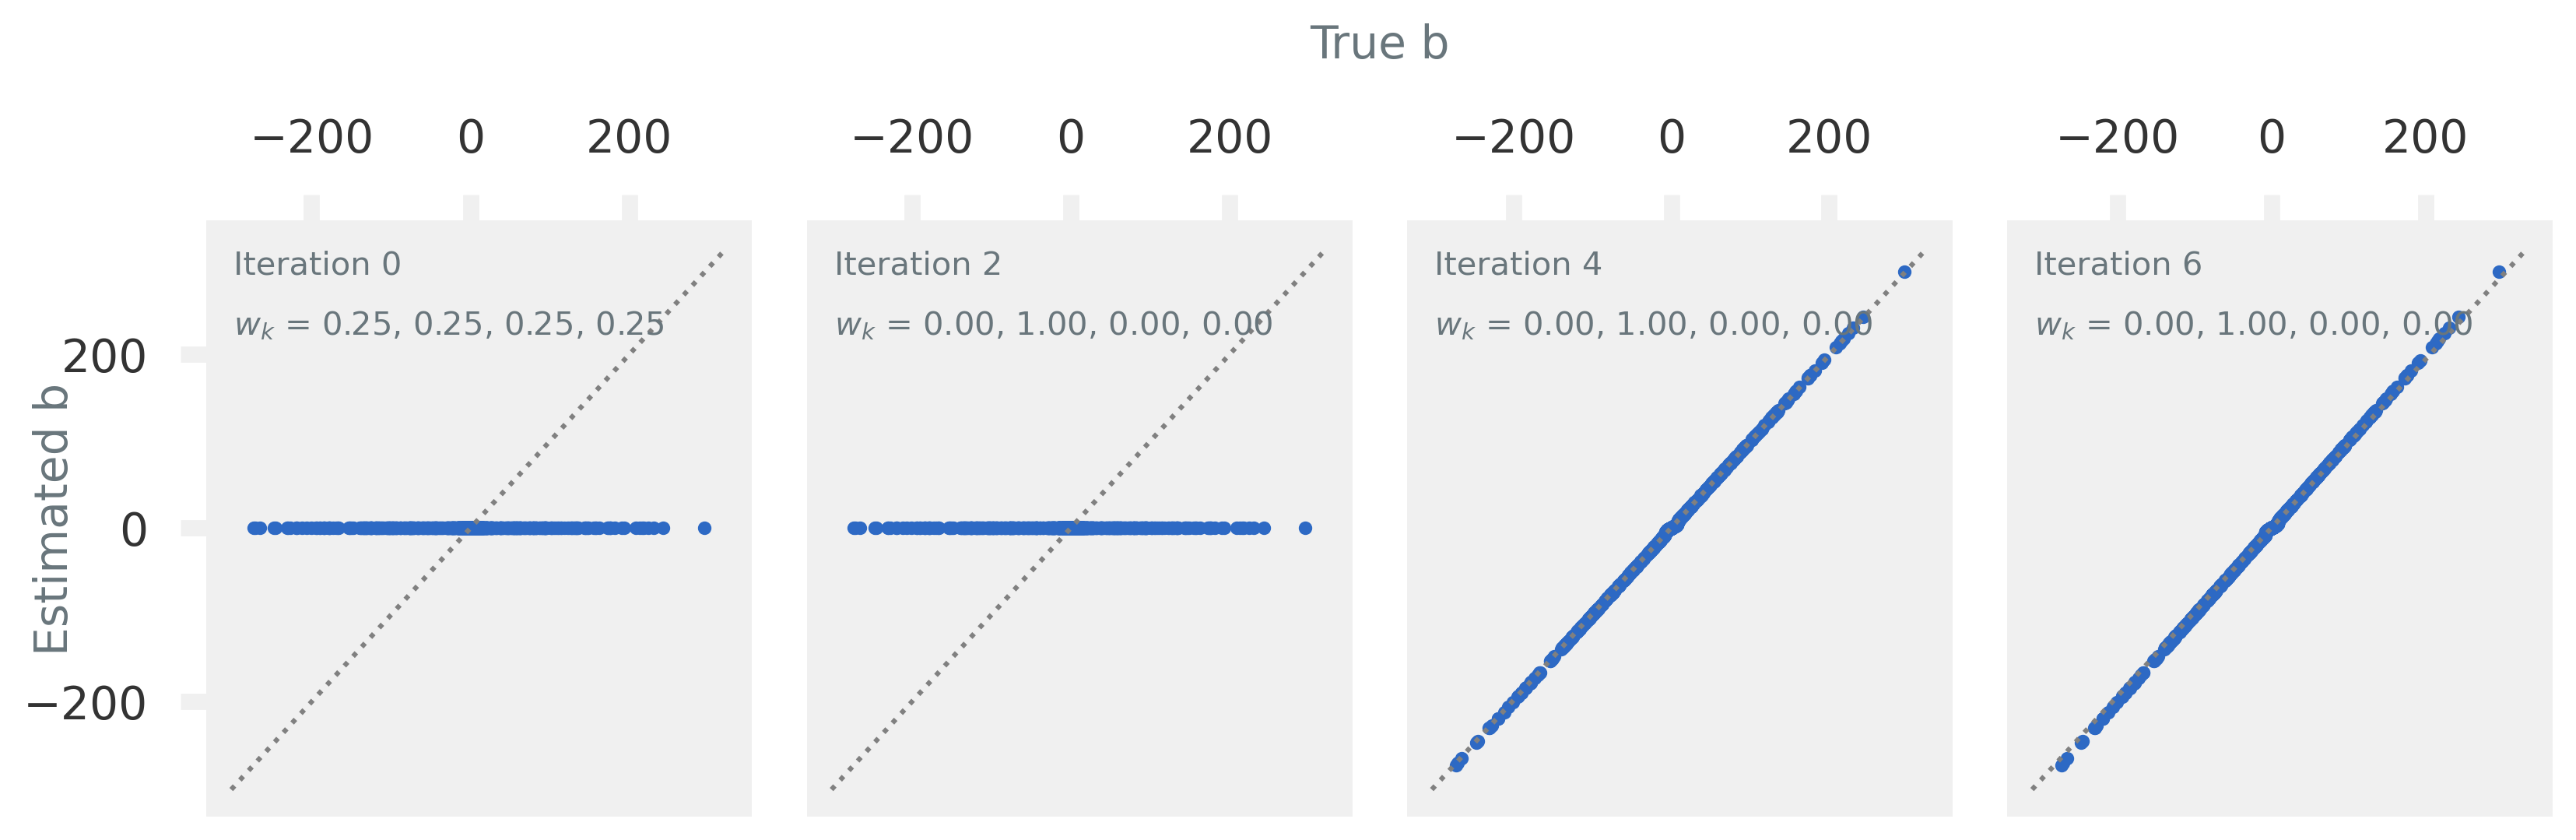

In [60]:
subplot_h = 1.8
nstep = 2
nplot = int(niter / nstep) + 1
ncol  = 4
nrow  = int(nplot / ncol + 1) if nplot%ncol != 0 else int(nplot / ncol)
figw  = ncol * subplot_h + (ncol - 1) * 0.3 + 1.2
figh  = nrow * subplot_h + (nrow - 1) * 0.3 + 1.5
figscale = 12.0 / figw

bgcolor = '#F0F0F0'
highlight_color = '#EE6868'
subdue_color = '#848f94'
text_color = '#69767c'

fig = plt.figure(figsize = (figw * figscale, figh * figscale))
axmain = fig.add_subplot(111)

for i in range(nplot):
    ax  = fig.add_subplot(nrow, ncol, i + 1)
    itr = i * nstep
    
    params = cg_min.allvecs[itr]
    z_it = params[:p]
    a_it = params[2*p:]
    #lj_it = params[p:2*p]
    w_it = softmax(a_it, base = softmax_base)
    b_it = shrink_theta(z_it, strue, w_it, sk, dj)
    
    ax.scatter(btrue, b_it, s=10)
    mpl_utils.plot_diag(ax)
    
    wtext = r'$w_k$ = ' + ', '.join([f"{w:.2f}" for w in w_it])
    itrtext = f"Iteration {itr}"
    
    ax.text(0.05, 0.85, wtext, va='top', ha='left', 
            transform=ax.transAxes, color = text_color, fontsize = 10)
    ax.text(0.05, 0.95, itrtext, va='top', ha='left', 
            transform=ax.transAxes, color = text_color, fontsize = 10)
    ax.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
    
    ax.set_facecolor(bgcolor)
    for side, border in ax.spines.items():
        border.set_visible(False)
    if i < ncol:
        ax.tick_params(top = True, labeltop = True, color = bgcolor, width = 5)
        #ax.set_xticks(np.log10([0.001, 0.01, 0.1, 1.0]))
    if i%ncol == 0:
        ax.tick_params(left = True, labelleft = True, color = bgcolor, width = 5)
    #ax.set_ylim(-0.1, 2.1)
    
axmain.tick_params(bottom = False, top = False, left = False, right = False,
                   labelbottom = False, labeltop = False, labelleft = False, labelright = False)
for side, border in axmain.spines.items():
    border.set_visible(False)
axmain.set_ylabel(r'Estimated b', labelpad = 40, color = text_color)
axmain.set_xlabel(r'True b', labelpad = 50, color = text_color)
axmain.xaxis.set_label_position('top') 


plt.tight_layout()
# plt.savefig(f'../plots/{fileprefix}.pdf', bbox_inches='tight')
# plt.savefig(f'../plots/{fileprefix}.png', bbox_inches='tight')
plt.show()

In [61]:
softmax_base

2.718281828459045

In [62]:
sk

array([  0.1,   1. ,  10. , 100. ])

In [49]:
## Gradient w.r.t wk
nmash = NormalMeansASHScaled(z, strue, wk, sk, d = dj)
tvar  = (strue * strue) / dj
v2_ld_ldwd = tvar.reshape(-1, 1) * nmash.logML_deriv.reshape(-1, 1) * nmash.logML_deriv_wderiv
l_wgrad = - nmash.logML_wderiv - v2_ld_ldwd
p_wgrad = lgrng.reshape(-1, 1) * tvar.reshape(-1, 1) * nmash.logML_deriv_wderiv
akjac  = np.log(softmax_base) * wk.reshape(-1, 1) * (np.eye(k) - wk)
np.sum(np.sum(l_wgrad + p_wgrad, axis = 0) * akjac, axis = 1)

array([-121.13234254,  -48.1336791 ,  169.26602163])

In [47]:
l_wgrad + p_wgrad

array([[-1.2369659 , -1.09329488, -0.66973922],
       [-1.17355024, -1.06746948, -0.75898027],
       [-1.22535186, -1.08836228, -0.68628586],
       ...,
       [-1.13790547, -1.05396746, -0.80812707],
       [-1.26935279, -1.10760057, -0.62304665],
       [-1.28936139, -1.11687554, -0.59376308]])

In [46]:
p_wgrad

array([[-0.15454458, -0.05852577,  0.21307035],
       [-0.10343583, -0.0377723 ,  0.14120813],
       [-0.14546346, -0.05468148,  0.20014494],
       ...,
       [-0.0728582 , -0.026201  ,  0.0990592 ],
       [-0.17928469, -0.06940534,  0.24869003],
       [-0.19417226, -0.07626709,  0.27043935]])

In [17]:
wk

array([0.33333333, 0.33333333, 0.33333333])

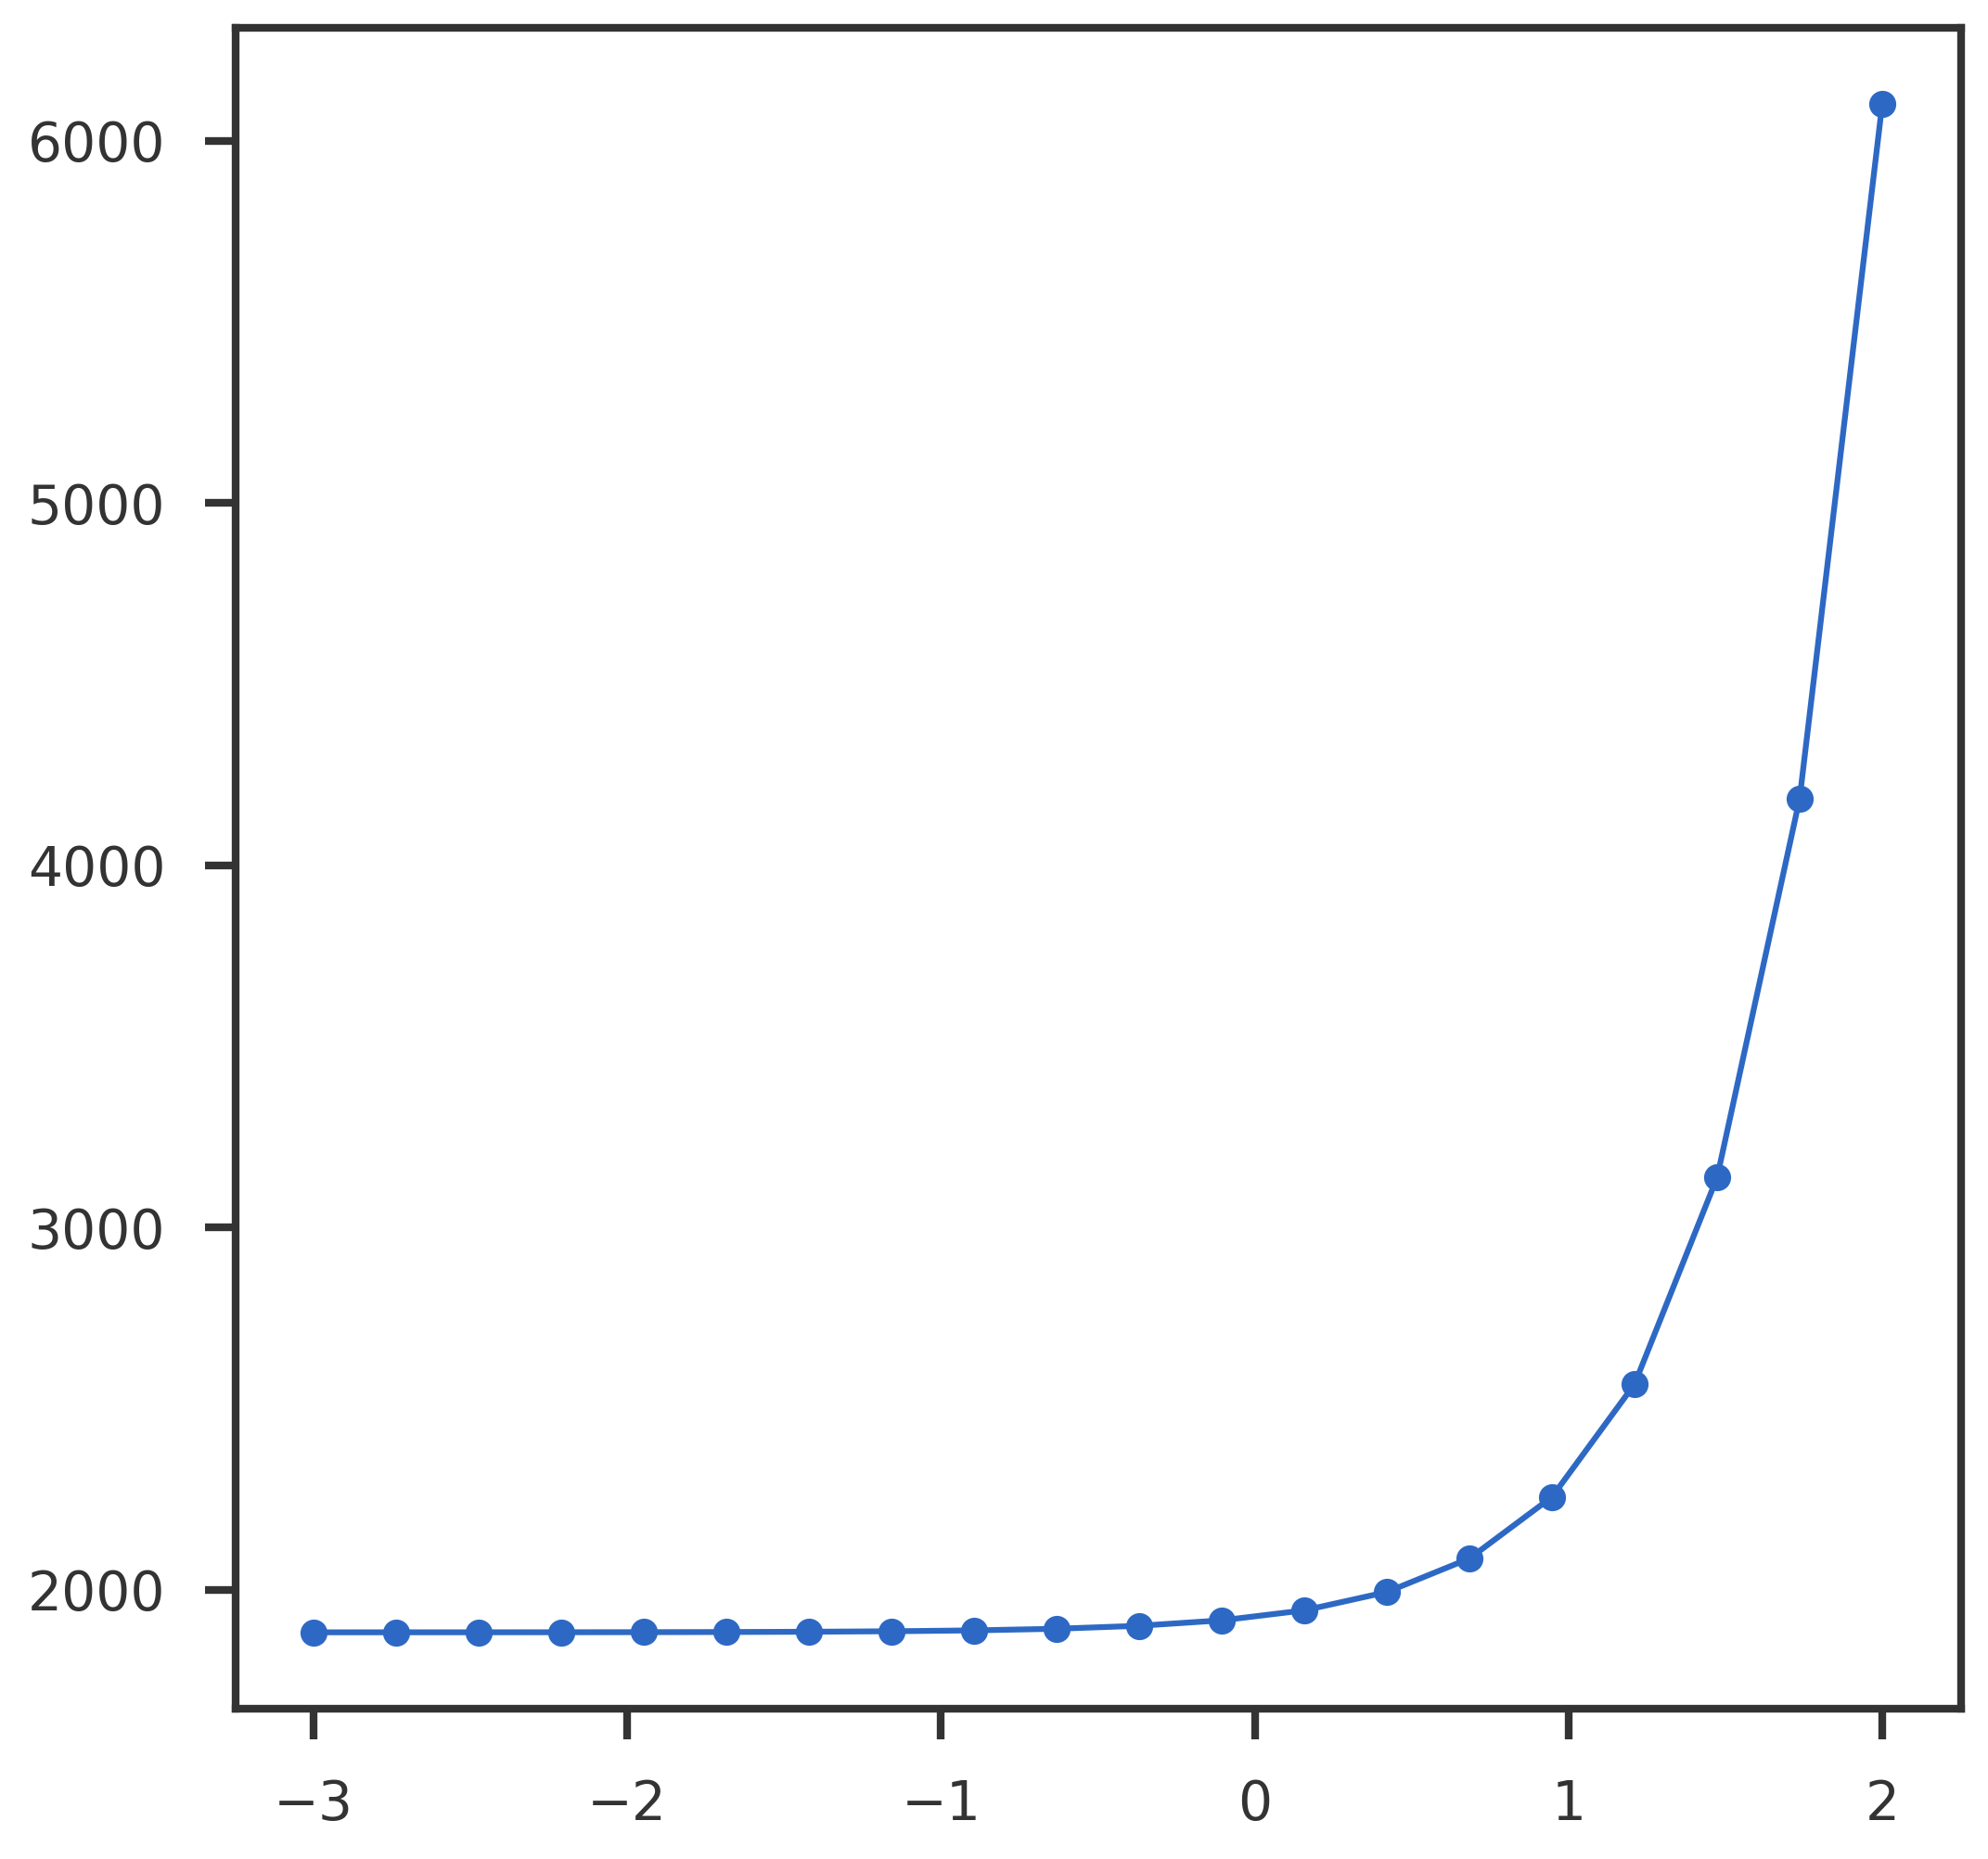

In [126]:
lgvar = np.logspace(-3, 2, 20)
obj_lgvar = np.zeros_like(lgvar)
for idx, l in enumerate(lgvar):
    lgrng = np.ones(btrue.shape[0]) * l
    obj = penalty_operator_lagrangian(z, wtrue, strue, sk, dj, lgrng, btrue)
    obj_lgvar[idx] = obj
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.log10(lgvar), obj_lgvar)
ax1.scatter(np.log10(lgvar), obj_lgvar)
plt.show()

In [127]:
winit, _ = initialize_ash_prior(k)
objinit = penalty_operator(z_newraph, winit, strue, sk, dj)
print(np.sum(objinit))

2408.8190917811025


In [11]:
btrue[btrue != 0].shape

(377,)

In [12]:
wtrue

array([0.8, 0.1, 0.1])